In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
import nltk
nltk.download('stopwords')

stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wei57\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def preprocess_text(text, include_stopwords_signal=False):
    print("text", text)
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ''.join([c for c in text if not c.isdigit()])
    words = text.split()
    if not include_stopwords_signal:
        words = [word for word in words if word not in stop_words]
    text = ' '.join([stemmer.stem(word) for word in words])
    print("preprocess text", text)
    return text

def train_word2vec(sentences):

    sentences = [s.split() for s in sentences]
    word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

    return word2vec_model

In [3]:
data = pd.read_csv('./test.csv', header=None)
documents = data[2].dropna()

include_stopwords_signal=False

documents = documents.map(lambda x: preprocess_text(x, include_stopwords_signal))

text Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.
preprocess text union repres worker turner newal say disappoint talk stricken parent firm feder mogul
text SPACE.com - TORONTO, Canada -- A second\team of rocketeers competing for the  #36;10 million Ansari X Prize, a contest for\privately funded suborbital space flight, has officially announced the first\launch date for its manned rocket.
preprocess text spacecom toronto canada secondteam rocket compet million ansari x prize contest forpriv fund suborbit space flight offici announc firstlaunch date man rocket
text AP - A company founded by a chemistry researcher at the University of Louisville won a grant to develop a method of producing better peptides, which are short chains of amino acids, the building blocks of proteins.
preprocess text ap compani found chemistri research univers louisvil grant develop method produc better peptid short chain amino ac

In [4]:
word2vec_model = train_word2vec(documents)

In [5]:
def split_sequences(sentences, word_vectors, n_steps_in, n_steps_out):
    X, y = [], []
    for sentence in sentences:
        vectors = [word_vectors[word] for word in sentence.split() if word in word_vectors]

        #print("len(vectors)", len(vectors))

        if len(vectors) >= n_steps_in + n_steps_out:
            for i in range(len(vectors) - n_steps_in - n_steps_out + 1):

                X.append(np.vstack(vectors[i:i + n_steps_in]))
                y.append(np.vstack(vectors[i + n_steps_in:i + n_steps_in + n_steps_out]))

    return np.array(X), np.array(y)

n_steps_in, n_steps_out = 3, 2

X, y = split_sequences(documents, word2vec_model.wv, n_steps_in, n_steps_out)

n_features = X.shape[2]

In [6]:
print(X.shape, y.shape)

(116590, 3, 100) (116590, 2, 100)


In [7]:
def build_and_train_model(X, y, activation='relu', epochs=50):
    model = Sequential()
    model.add(LSTM(200, activation=activation, input_shape=(n_steps_in, n_features)))
    model.add(RepeatVector(n_steps_out))
    model.add(LSTM(200, activation=activation, return_sequences=True))
    model.add(TimeDistributed(Dense(n_features)))
    model.compile(optimizer='adam', loss='mse')

    model.fit(X, y, epochs=epochs, verbose=1)
    return model

In [8]:
model = build_and_train_model(X, y, activation='relu')
predictions = model.predict(X, verbose=1)
rmse_result = np.sqrt(np.mean((y - predictions)**2, axis=(1, 2)))

Epoch 1/50


c:\Users\wei57\.conda\envs\CS410\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3644/3644 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - loss: 0.0568
Epoch 2/50
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - loss: 0.0536
Epoch 3/50
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - loss: 0.0534
Epoch 4/50
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - loss: 0.0532
Epoch 5/50
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - loss: 0.0532
Epoch 6/50
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - loss: 0.0530
Epoch 7/50
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - loss: 0.0530
Epoch 8/50
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - loss: 0.0529
Epoch 9/50
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - loss: 0.0527
Epoch 10/50
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - loss: 0.0527
Epoch 11/50
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - loss: 0.0527
Epoch 12/50
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - loss: 0.0526
Epoch 13/50
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 0.0525
Epoch 14/50
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 0.0525
Epoch 15/50
3644/3644 ━━━━

Campare relu and tanh

In [9]:
relu_model = build_and_train_model(X, y, activation='relu')
predictions = relu_model.predict(X, verbose=1)
relu_rmse = np.sqrt(np.mean((y - predictions)**2, axis=(1, 2)))

Epoch 1/50


c:\Users\wei57\.conda\envs\CS410\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3644/3644 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - loss: 0.0572
Epoch 2/50
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.0538
Epoch 3/50
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 0.0534
Epoch 4/50
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 0.0533
Epoch 5/50
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 0.0530
Epoch 6/50
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 0.0529
Epoch 7/50
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.0531
Epoch 8/50
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 0.0528
Epoch 9/50
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 0.0529
Epoch 10/50
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - loss: 0.0527
Epoch 11/50
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.0528
Epoch 12/50
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.0528
Epoch 13/50
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 0.0523
Epoch 14/50
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 0.0523
Epoch 15/50
3644/3644 ━━━━

In [ ]:
tanh_model = build_and_train_model(X, y, activation='tanh')
predictions = tanh_model.predict(X, verbose=1)

tanh_rmse = np.sqrt(np.mean((y - predictions)**2, axis=(1, 2)))

Epoch 1/50
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - loss: 0.0566
Epoch 2/50
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.0547
Epoch 3/50
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.0540
Epoch 4/50
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 0.0537
Epoch 5/50
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.0536
Epoch 6/50
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.0533
Epoch 7/50
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.0529
Epoch 8/50
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.0530
Epoch 9/50
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.0530
Epoch 10/50
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.0527
Epoch 11/50
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 0.0528
Epoch 12/50
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 0.0527
Epoch 13/50
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 0.0526
Epoch 14/50
3644/3644 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.0526
Epoch 15/50
364

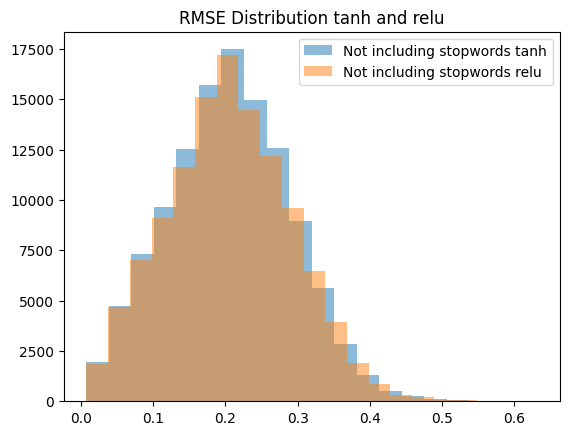

In [12]:
histograms = {}

plt.hist(tanh_rmse, bins=20, alpha=0.5, label=f'Not including stopwords tanh')
plt.hist(relu_rmse, bins=20, alpha=0.5, label=f'Not including stopwords relu')
plt.legend()
plt.title(f'RMSE Distribution tanh and relu')
plt.show()

histograms['tanhrelu'] = (tanh_rmse, relu_rmse)

Predict

In [15]:
longest_doc = documents.loc[documents.map(lambda x: len(x.split())).idxmax()]
longest_doc_preprocessed = preprocess_text(longest_doc, include_stopwords_signal=False)
words = longest_doc_preprocessed.split()
longest_sentence = ' '.join(words[-5:-2])
longest_sentence


text duke univers supernova earli warn system snew detect ghostlik neutrino particl earliest eman immens explos death throe larg star alert astronom blast see flash snew could allow astronom chanc make unpreced observ earli turnon supernova wrote author articl new system septemb issu new journal physic also note supernova ever observ soon birth big star end live explos gravit collaps complet even brilliant flash light usual announc extrem rare supernova event stay trap insid unseen astronom first hour day
preprocess text duke univ supernova earli warn system snew detect ghostlik neutrino particl earliest eman immen explo death throe larg star alert astronom blast see flash snew could allow astronom chanc make unprec observ earli turnon supernova wrote author articl new system septemb issu new journal physic also note supernova ever observ soon birth big star end live explo gravit collap complet even brilliant flash light usual announc extrem rare supernova event stay trap insid unseen 

'unseen astronom first'

In [16]:
input_sequence = np.array([word2vec_model.wv[word] for word in longest_sentence.split()[:n_steps_in]])
#print("input_sequence", input_sequence)
input_sequence = input_sequence.reshape((1, n_steps_in, n_features))
predicted_vectors = tanh_model.predict(input_sequence, verbose=0)

def find_closest_words(predicted_vectors, word_vectors):
    predicted_words = []
    for vector in predicted_vectors[0]:
        similar_words = word_vectors.similar_by_vector(vector, topn=3)
        predicted_words.append(similar_words[0][0])
        print(similar_words)
    return predicted_words

predicted_words = find_closest_words(predicted_vectors, word2vec_model.wv)
print("Predicted words:", predicted_words)

[('follow', 0.9998051524162292), ('coach', 0.9997892379760742), ('point', 0.9997866749763489)]
[('go', 0.9998406767845154), ('coach', 0.9998307824134827), ('put', 0.99982088804245)]
Predicted words: ['follow', 'go']
